In [1]:
from __future__ import print_function, division, absolute_import, unicode_literals
%load_ext tensorboard
import tensorflow as tf
tf.__version__

'2.0.0-dev20191002'

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Setting perameters

In [4]:
im_width = 256
im_height = 256
border = 5
path_train = os.path.join( os.getcwd(), 'input',  'train')
path_test = os.path.join( os.getcwd(), 'input',  'test')

In [5]:
def get_data(path, train=True):
    ids = next(os.walk(path + "\images"))[2]
    mask_ids = next(os.walk(path + '\masks'))[2]
    X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
    if train:
        y = np.zeros((len(mask_ids), im_height, im_width, 3), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        img = imread(path + '/images/' + id_)
        x_img = img_to_array(img)
        x_img = resize(x_img, (256, 256, 3), mode='constant', preserve_range=True)
        X[n, ..., 0] = x_img[:,:,0].squeeze() / 255
        X[n, ..., 1] = x_img[:,:,1].squeeze() / 255
        X[n, ..., 2] = x_img[:,:,2].squeeze() / 255
    for n, id_ in tqdm_notebook(enumerate(mask_ids), total=len(mask_ids)):
        if train:
            mask = img_to_array(load_img(path + '/masks/' + id_ , grayscale=False))
            mask = resize(mask, (256, 256, 3), mode='constant', preserve_range=True)
        if train:
            y[n, ..., 0] = mask[:,:,0].squeeze() / 255
            y[n, ..., 1] = mask[:,:,1].squeeze() / 255
            y[n, ..., 2] = mask[:,:,2].squeeze() / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X

In [6]:
X, y = get_data(path_train, train=True)

Getting and resizing images ... 



Done!


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [9]:
def plot_img(ix):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    ax[0].imshow(X_train[ix])
    ax[0].set_title('Image')

    ax[1].imshow(y_train[ix])
    ax[1].set_title('mask');

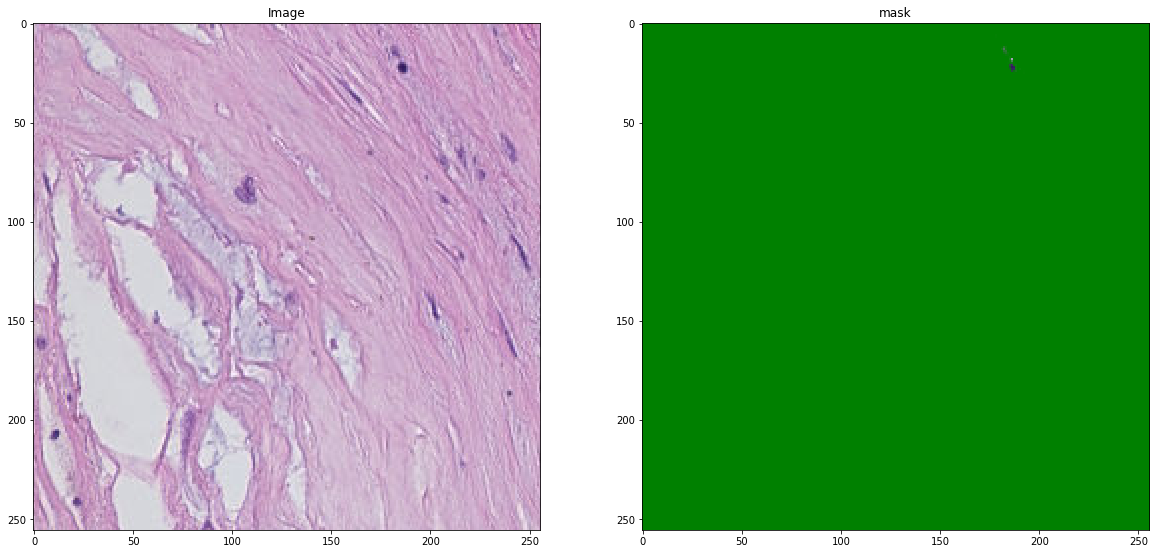

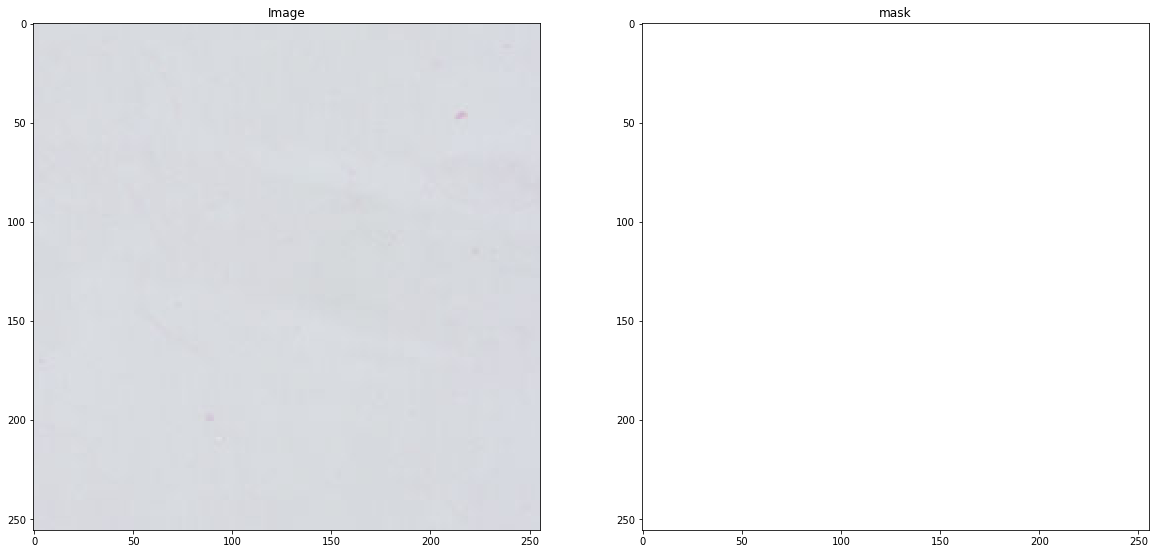

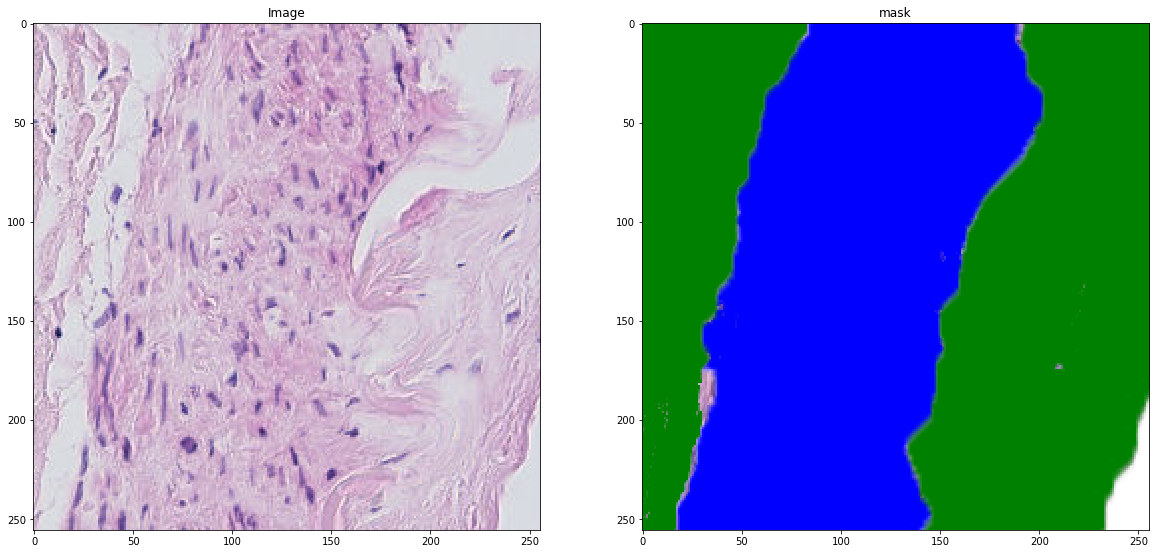

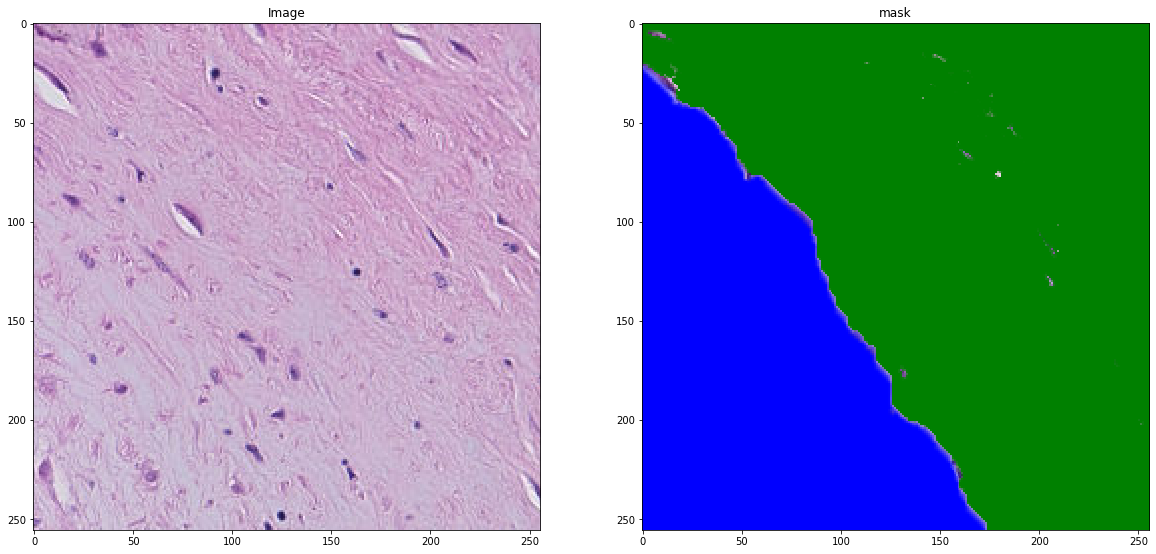

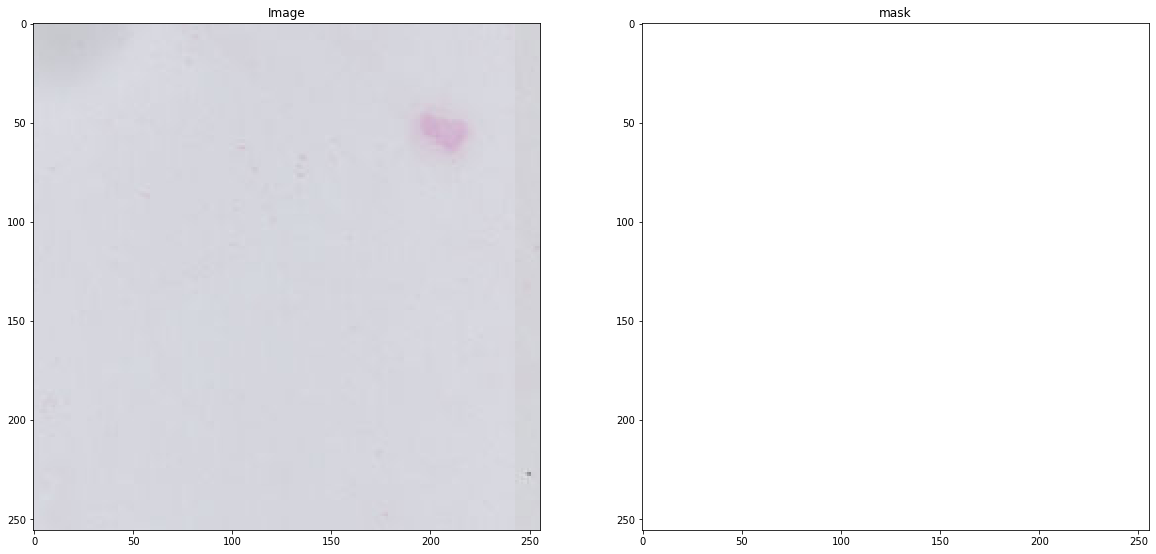

In [10]:
for i in range(0,5):
    ix = random.randint(0, len(X_train))
    plot_img(ix)

In [11]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [12]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [13]:
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [14]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[dice_coef, 'acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-unet-basic_tf2.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(logdir, histogram_freq=1)
]

In [16]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 408 samples, validate on 86 samples
Epoch 1/100
384/408 [===========================>..] - ETA: 3:42 - loss: 0.7960 - dice_coef: 0.4691 - acc: 0.329 - ETA: 3:04 - loss: 0.7662 - dice_coef: 0.5406 - acc: 0.399 - ETA: 2:46 - loss: 0.7452 - dice_coef: 0.5989 - acc: 0.459 - ETA: 2:31 - loss: 0.7293 - dice_coef: 0.6579 - acc: 0.527 - ETA: 2:12 - loss: 0.7146 - dice_coef: 0.6915 - acc: 0.567 - ETA: 1:56 - loss: 0.7029 - dice_coef: 0.7187 - acc: 0.599 - ETA: 1:40 - loss: 0.6937 - dice_coef: 0.7306 - acc: 0.613 - ETA: 1:23 - loss: 0.6823 - dice_coef: 0.7528 - acc: 0.642 - ETA: 1:06 - loss: 0.6719 - dice_coef: 0.7706 - acc: 0.664 - ETA: 48s - loss: 0.6618 - dice_coef: 0.7837 - acc: 0.681 - ETA: 30s - loss: 0.6537 - dice_coef: 0.7955 - acc: 0.69 - ETA: 13s - loss: 0.6459 - dice_coef: 0.8066 - acc: 0.7108
Epoch 00001: val_loss improved from inf to 0.60007, saving model to model-unet-basic_tf2.h5
408/408 [==============================] - 237s 581ms/sample - loss: 0.6405 - dice_coef: 0.81

KeyboardInterrupt: 

NameError: name 'results' is not defined

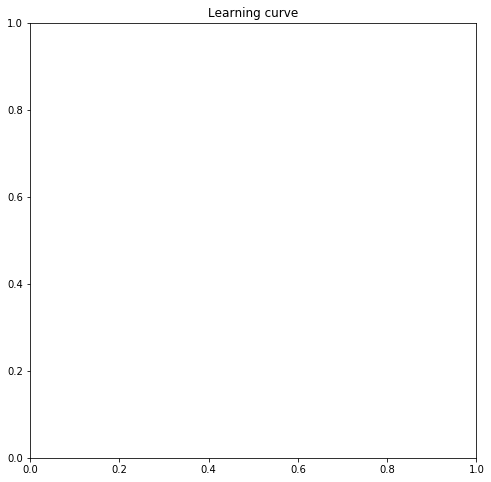

In [17]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [18]:
# Load best model
model.load_weights('model-unet-basic_tf2.h5')

In [19]:
model.evaluate(X_valid, y_valid, verbose=1)

86/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.48090765503949895, 0.9252079, 0.83494496]

In [20]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

408/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 29s 71ms/sample
86/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [21]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix])
   
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
   
    ax[2].set_title('Mask Predicted')
    


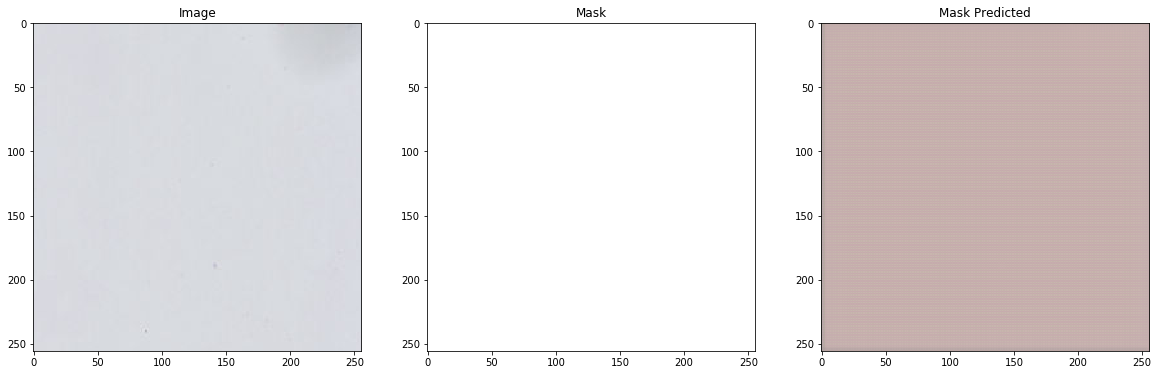

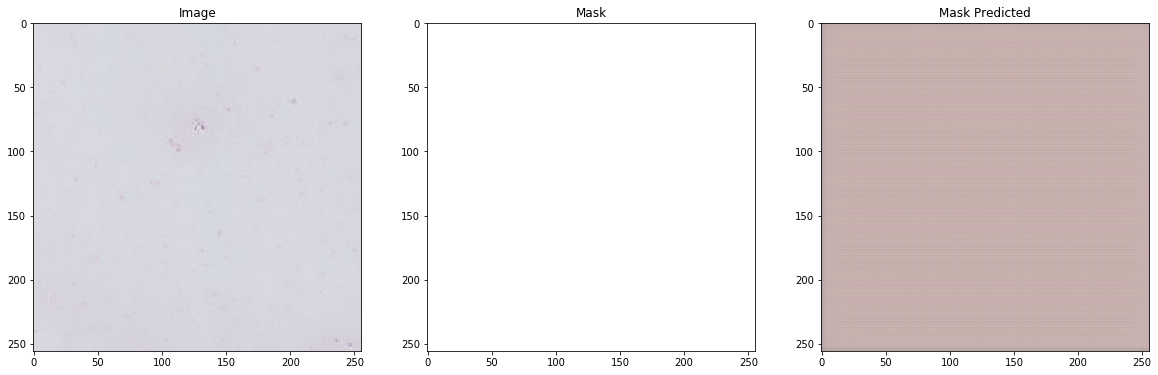

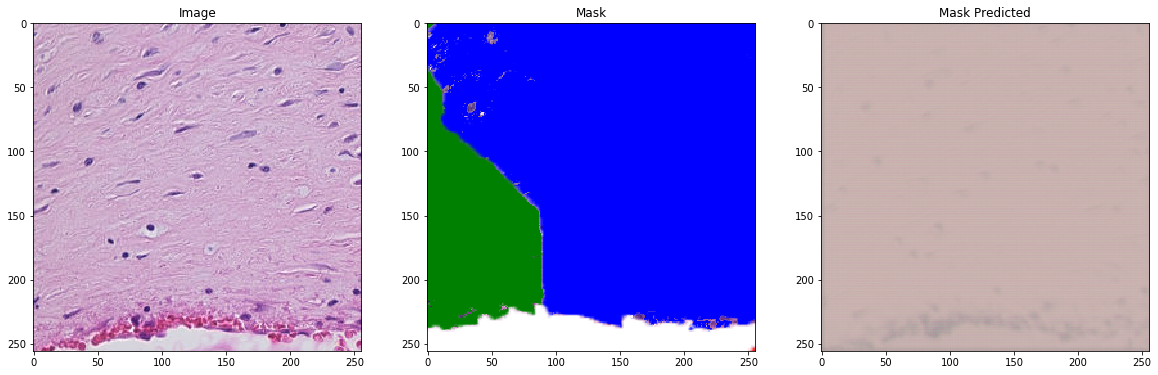

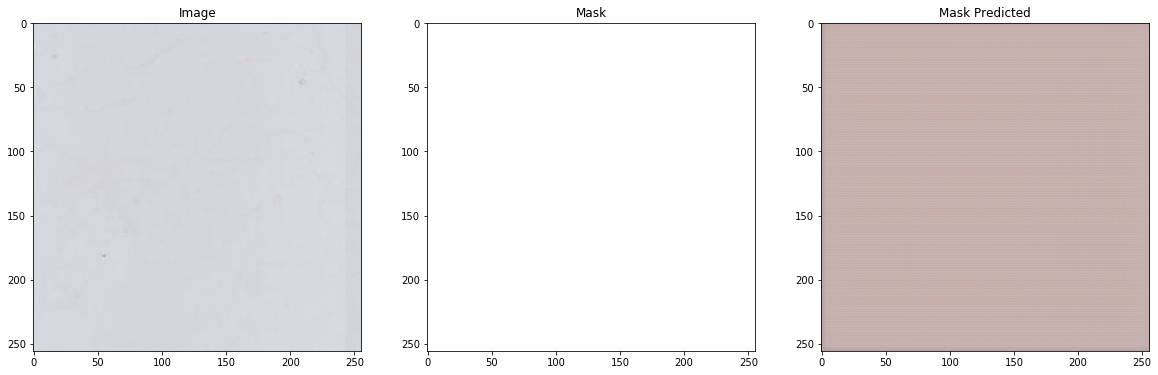

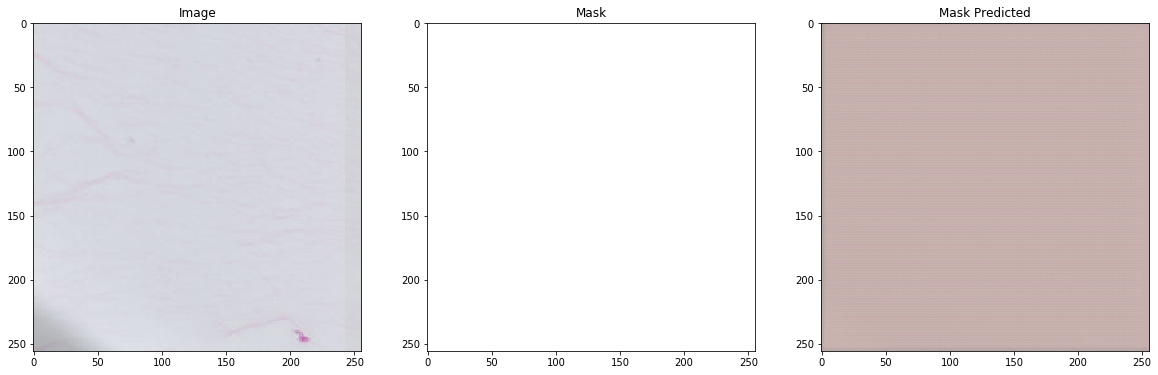

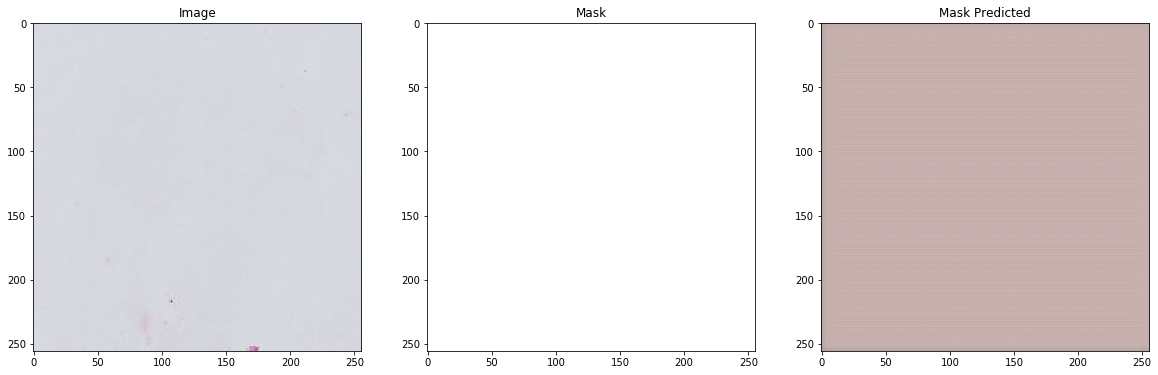

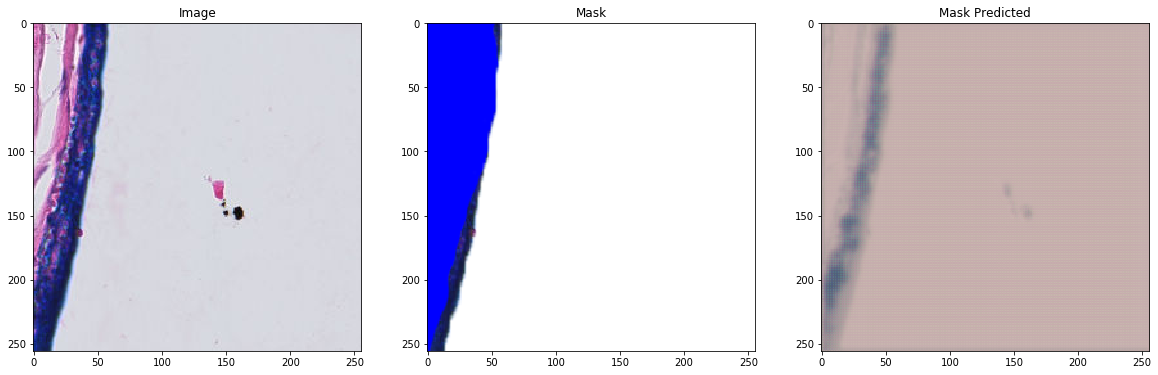

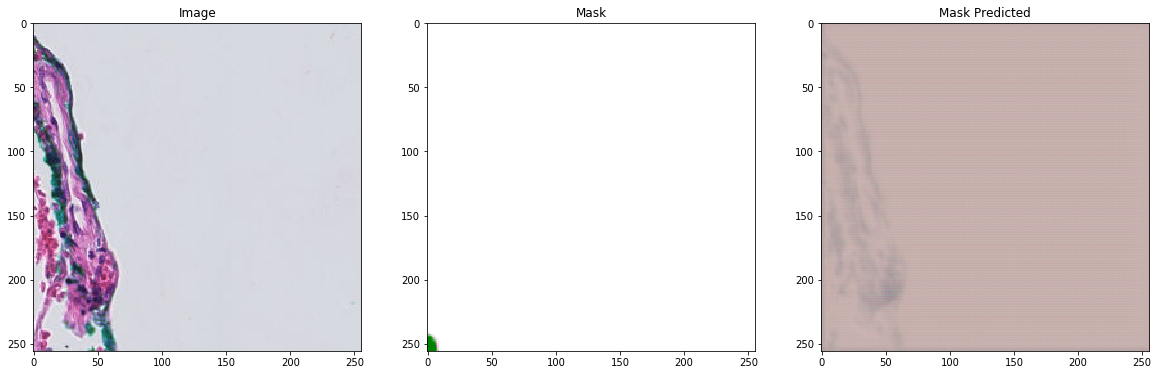

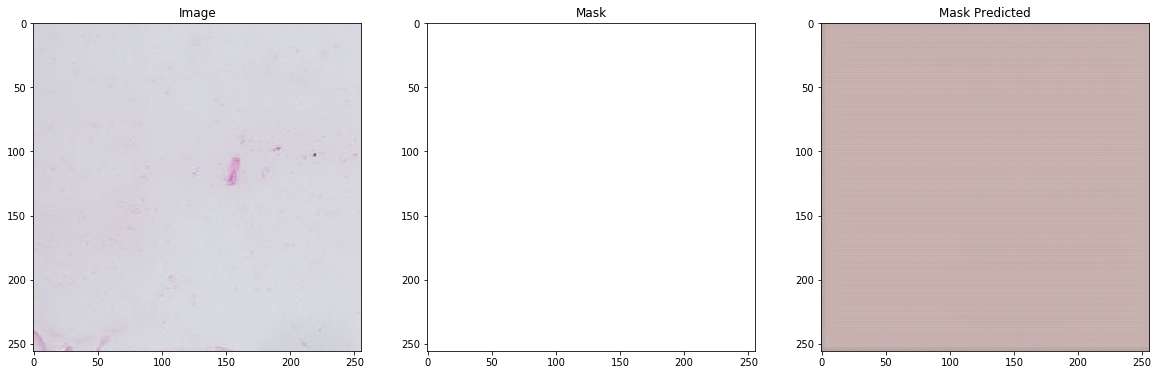

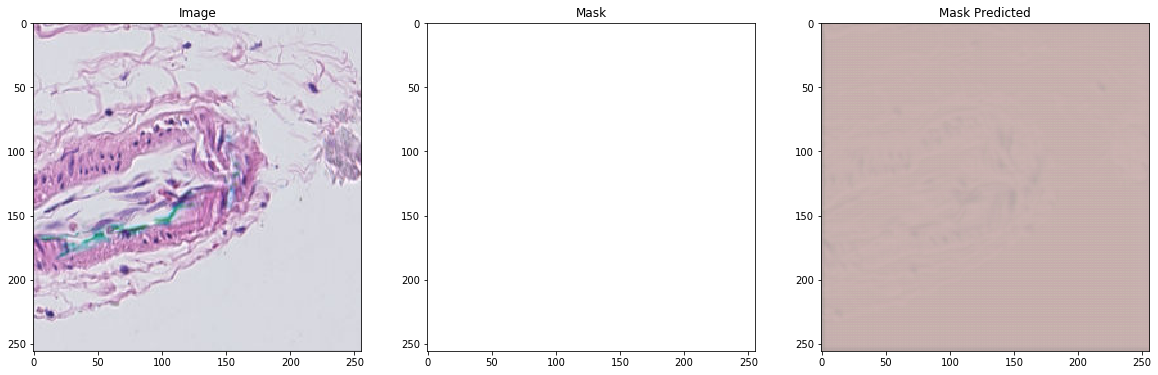

In [22]:
# Check if training data looks all right
for i in range(0,10):
    plot_sample(X_train, y_train, preds_train, preds_train_t)

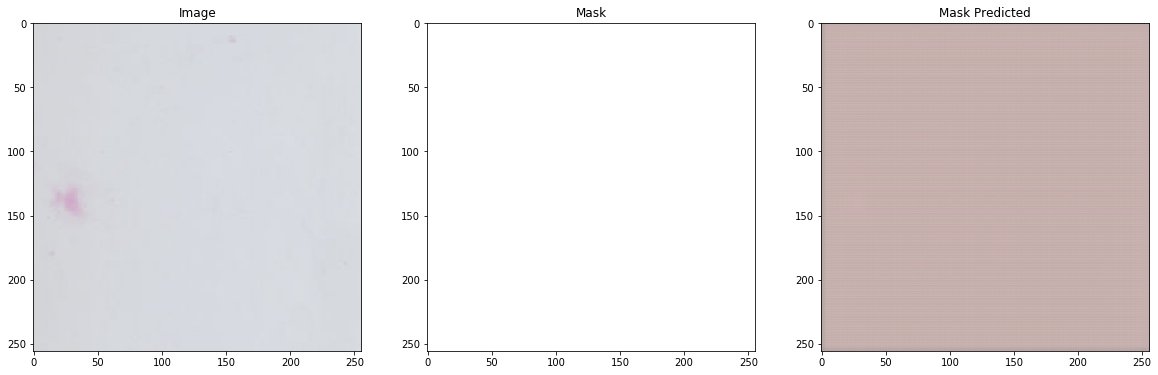

In [23]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [24]:
path_test = os.path.join( os.getcwd(), 'input',  'test')
X_test, y_test = get_data(path_test, train=True)

Getting and resizing images ... 



Done!


In [25]:
preds_test = model.predict(X_test, verbose=1)

22/1 [====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 1s 64ms/sample


In [26]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

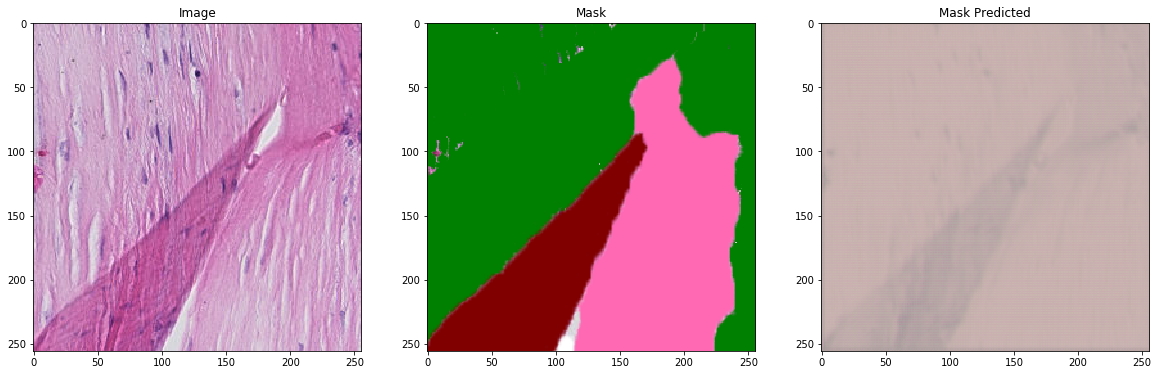

In [27]:
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=15)

In [28]:
path_big = os.path.join(os.getcwd(), 'input', 'big')
X_big, y_big = get_data(path_big, train=True)

Getting and resizing images ... 



Done!


In [29]:
preds_big = model.predict(X_big, verbose=1)

1/1 [==============================] - 0s 77ms/sample


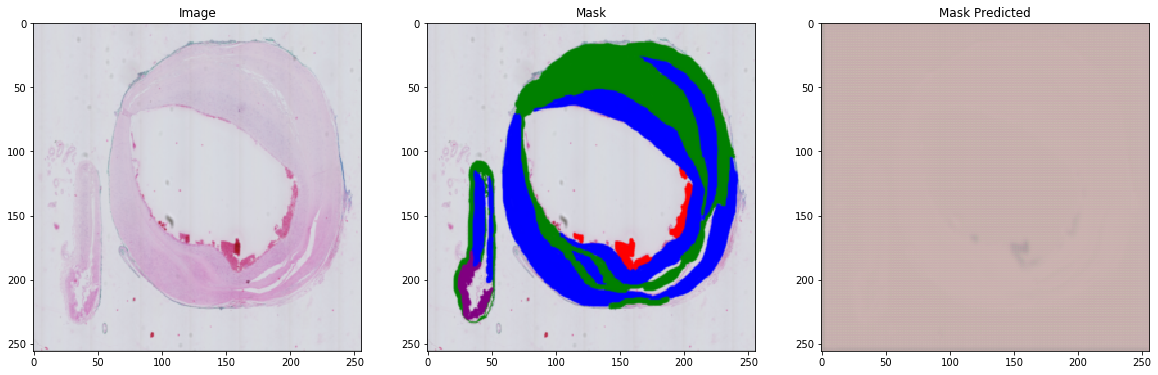

In [30]:
preds_big_t = (preds_big > 0.5).astype(np.uint8)
plot_sample(X_big, y_big, preds_big, preds_big_t, ix=0)

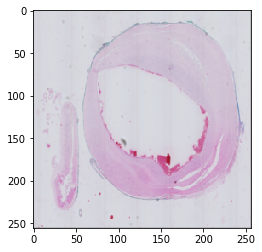

In [31]:
plt.imshow(X_big[0])

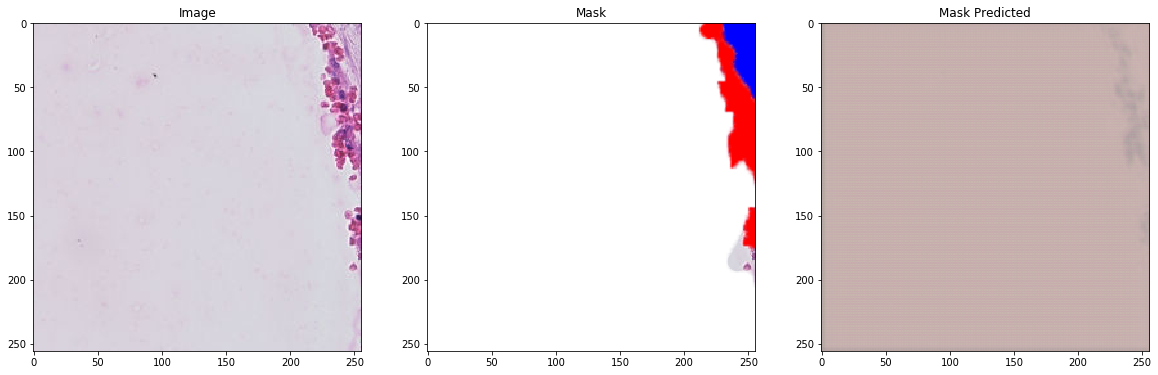

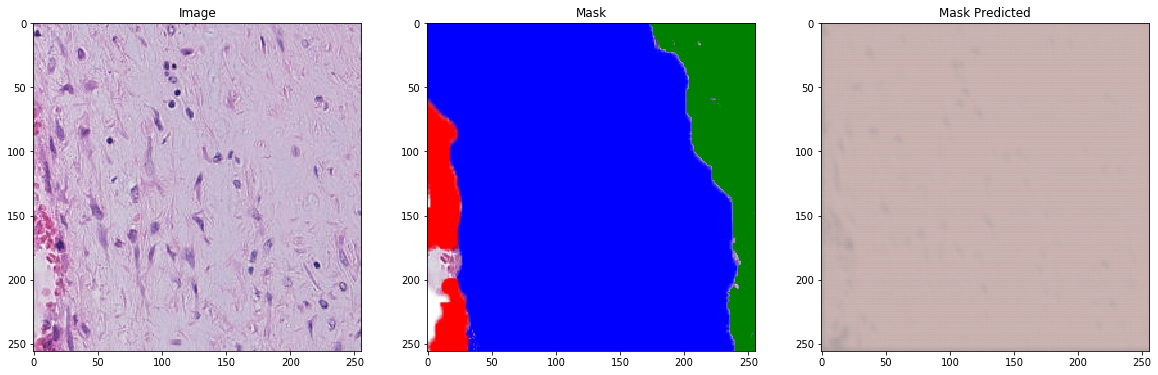

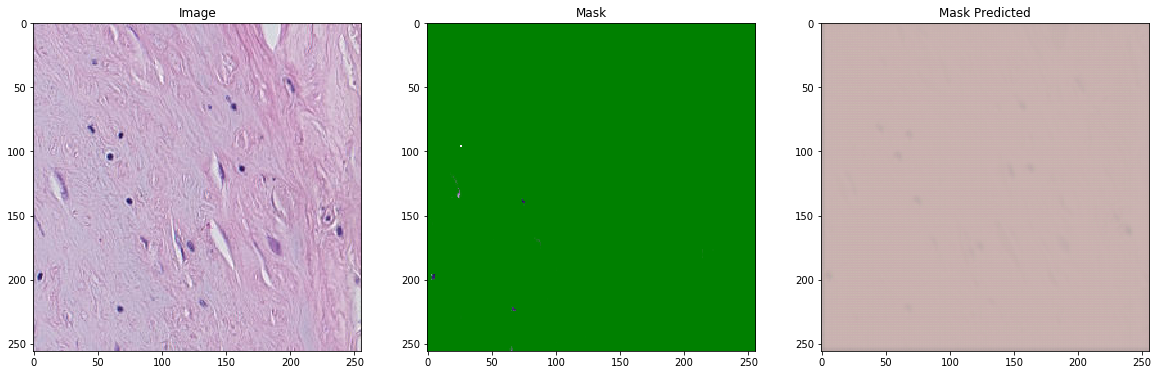

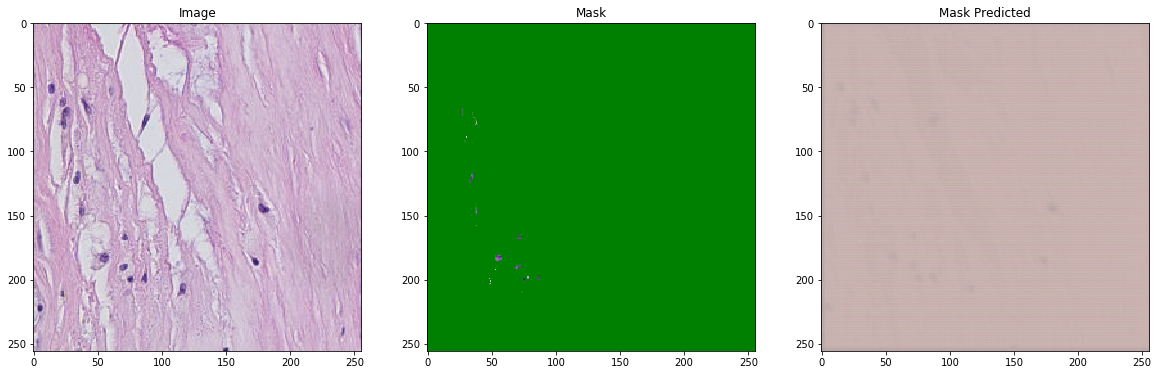

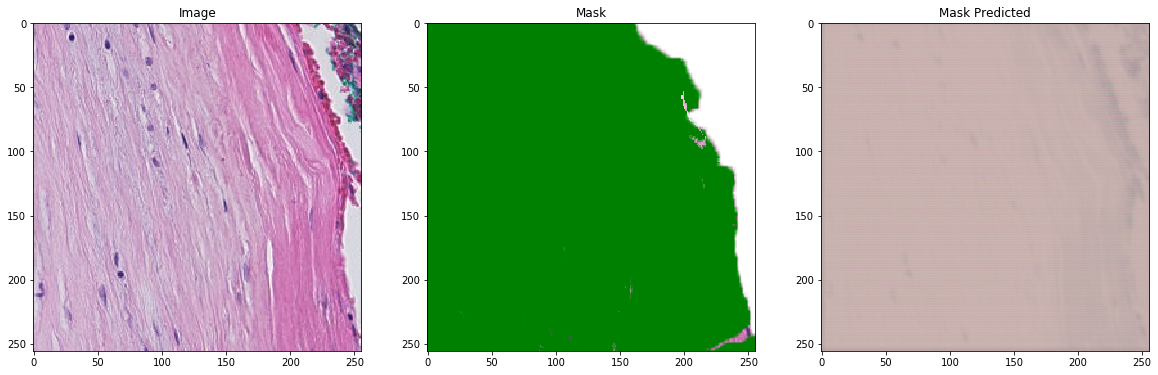

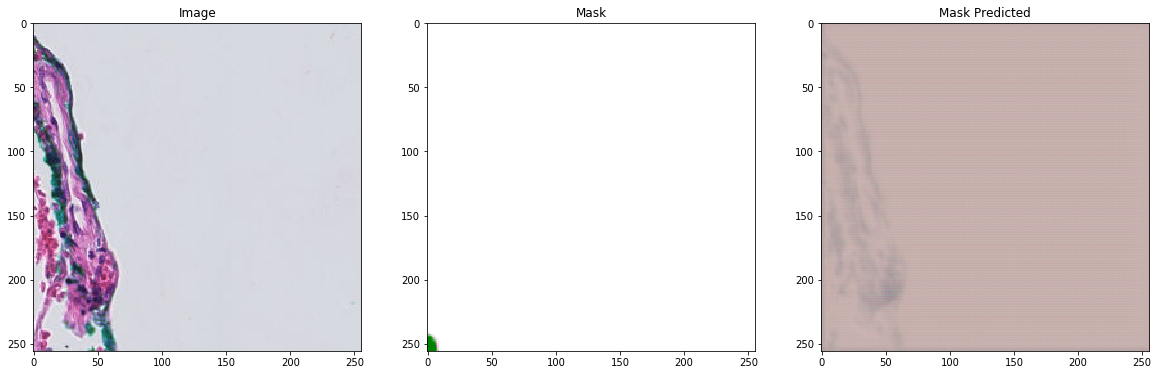

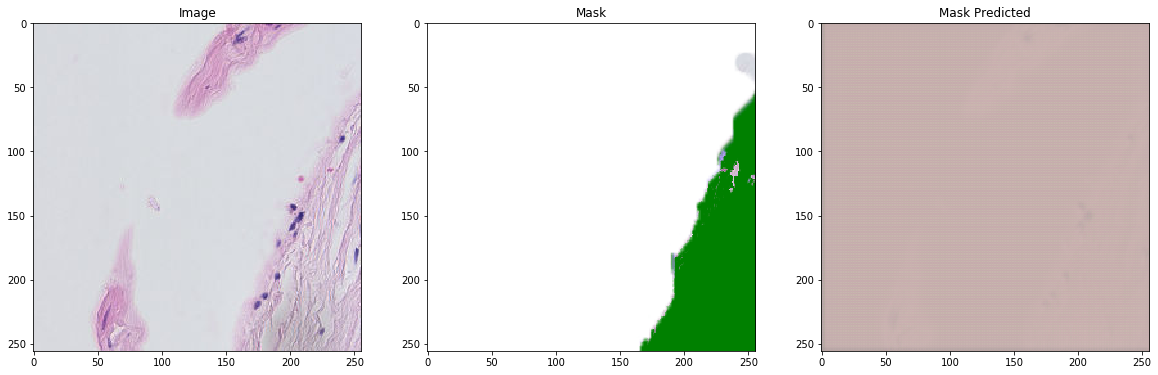

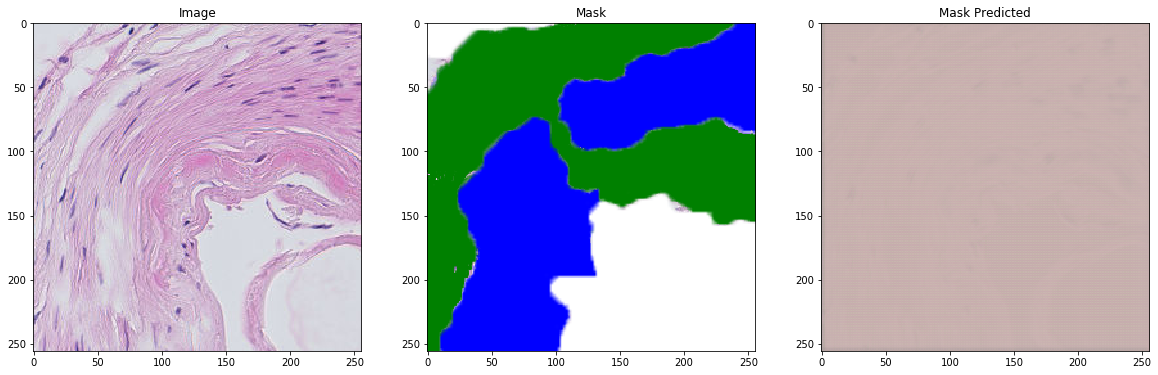

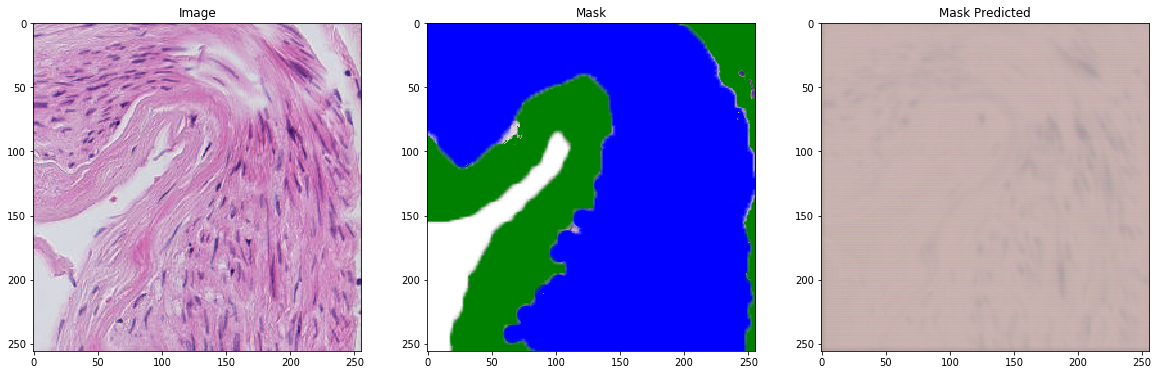

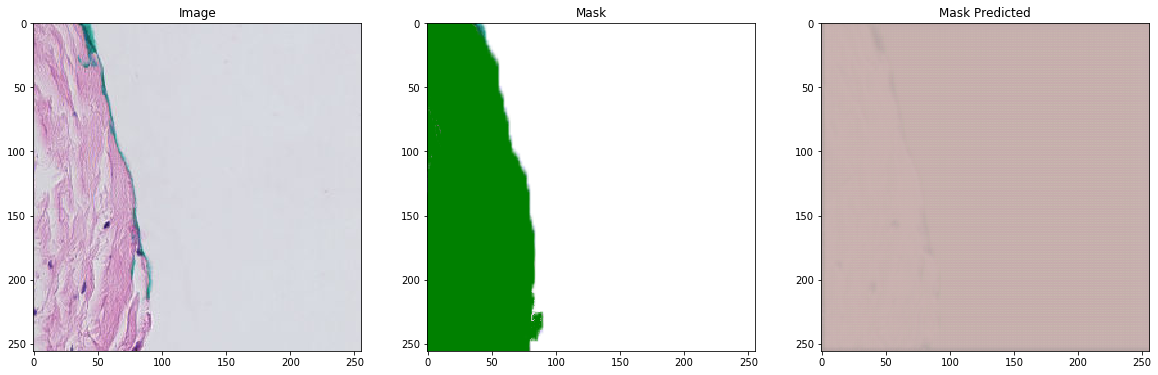

In [32]:
for i in range(10):
    plot_sample(X_test, y_test, preds_test, preds_test_t, ix=i)

In [33]:
%tensorboard --logdir log\s

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 5128.